# EEG brainwave for confusion
                

## Packages and settings

In [197]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import skew
from scipy import stats
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures 
from math import sqrt
from sklearn.model_selection import cross_val_predict

## 1. Load and clean data

In [150]:
# EEG_data taken from  https://www.kaggle. com/wanghaohan/eeg-brain-wave-for-confusion

dataset = pd.read_csv('eeg-brain-wave-for-confusion/EEG_data.csv') # Load Data
dataset.columns =  ["Subject ID", "Video ID", "Attention", "Mediation", "Raw", "Delta", "Theta", 
                    "Alpha 1", "Alpha 2", "Beta 1", "Beta 2", "Gamma 1", "Gamma 2", 
                    "predefined label", "user-defined label"]


dataset_mean = dataset.groupby(["Subject ID", "Video ID"]).mean().reset_index()
dataset_mean["Subject ID"] = [int(x) for x in dataset_mean["Subject ID"]]
dataset_mean["Video ID"] = [int(x) for x in dataset_mean["Video ID"]]

## 2. Outlier Analysis

In [151]:
attention = dataset_mean["Attention"]
mediation = dataset_mean["Mediation"]

def outlier_detection(data, m=2): # use standard deviation and mean for outlier detection
    std = np.std(data)
    mu = np.mean(data)
    return [i for i,j in enumerate(data) if abs(j - mu) > m * std] # 
    
outliers_attention = outlier_detection(attention) # outliers for attention
outlier_mediation = outlier_detection(mediation)  # outliers for mediation

# search for same outliers in attention and mediation 
same_outliers = [j for j in outliers_attention if np.isin(j,outlier_mediation)] 
subjects = [dataset_mean["Subject ID"][i] for i in same_outliers] # get Subject for both outliers

print("Subjects: ", subjects)
print("Observations:",same_outliers)

# exclude outliers 
dataset_mean = pd.concat([dataset_mean[0:60],dataset_mean[70:100]])

Subjects:  [3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
Observations: [33, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]


We decided to exclude the observations 60 to 69. All of them occured in a single subject which might indicate that these are likly caused by individual, accidantial not representative errors. The observation 33 is retained. We could not make any reasonable assumption about its cause and took the small size of our dataset into account by making this decision.

## 3. Predictor distributions and correlations

skewed:  -0.44229432852853307
log_data: skeness corrected
one_over_data: still skewed
sqrt_data: skeness corrected
squared_data: still skewed


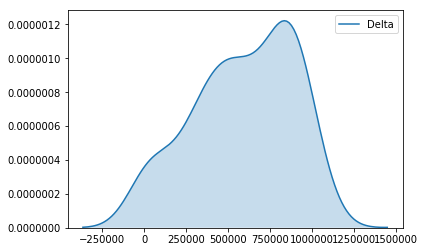

skewed:  0.3254501113004684
log_data: skeness corrected
one_over_data: still skewed
sqrt_data: skeness corrected
squared_data: still skewed


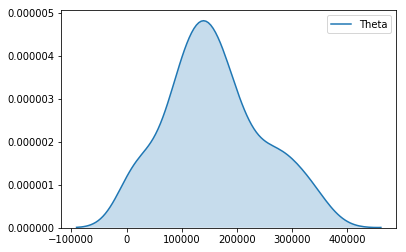

not skewed


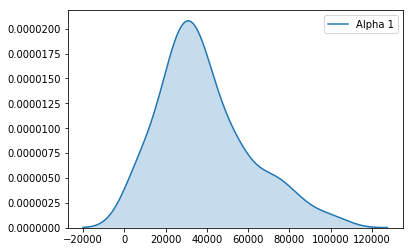

not skewed


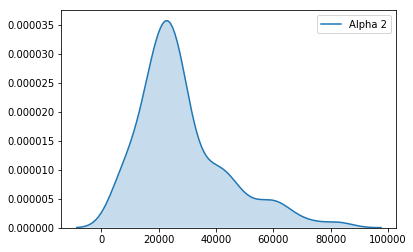

not skewed


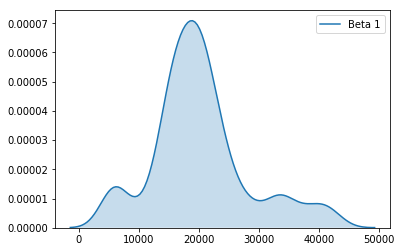

not skewed


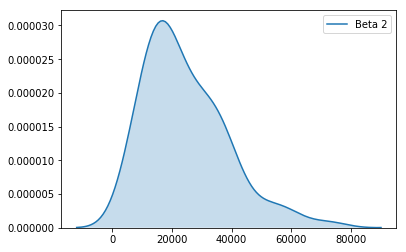

skewed:  1.2453652363811614
log_data: skeness corrected
one_over_data: still skewed
sqrt_data: skeness corrected
squared_data: still skewed


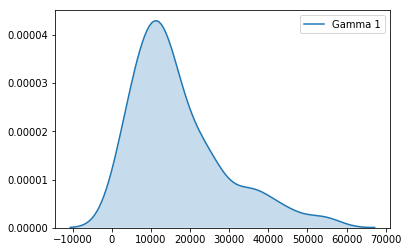

not skewed


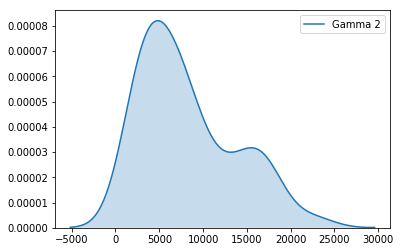

In [152]:
index = range(5,13) # the indexes of our predictors in the dataset

for i in index:
    data = dataset_mean.iloc[:,i]
    sns.kdeplot(data,shade=True)
    
    if np.amax(data)/np.amin(data) > 20: # rule of thumb
        skw = skew(data,0)
        print("skewed: ", skw)
        
        # different standard data transformations
        log_data = np.log(data) # log
        one_over_data = [1/x for x in data] # 1/x
        sqrt_data = np.sqrt(data) # square root
        squared_data = [x**2 for x in data] # x^2
        
        transformations = {"log_data": log_data, 
                           "one_over_data": one_over_data, 
                           "sqrt_data": sqrt_data, 
                           "squared_data": squared_data}
        
        # test data with different transformations again
        for name,trans in transformations.items():
            if np.amax(trans)/np.amin(trans) > 20: # rule of thumb
                print("%s: still skewed" % name)
            else:
                print("%s: skeness corrected" % name)
        
    else:
        print("not skewed")
    plt.show()  
    dataset_mean.iloc[:,i] = log_data # use the log data transformation

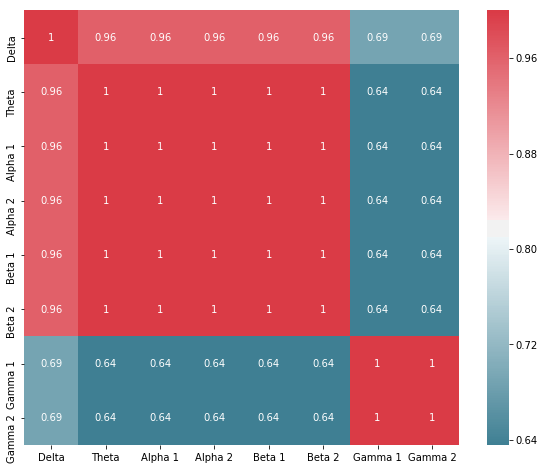

In [154]:
predictors = dataset_mean.iloc[:,5:13]

f, ax = plt.subplots(figsize=(10, 8))
corr = predictors.corr(method='pearson')
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

The correlation matrix clearly shows three different correltation blocks:
- Delta
- Theta, Alpha 1, Alpha 2, Beta 1, Beta 2
- Gamma 1, Gamma 2

## 4. Basic linear Regression  

Text(0.5,1,'Attention')

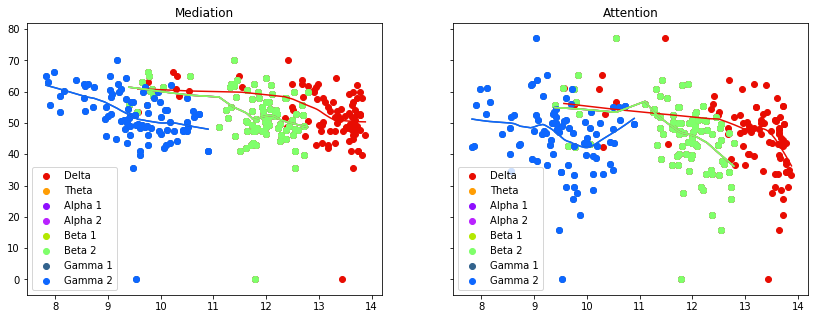

In [196]:
index = range(5,13)
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,5), sharey=True)
t = ["#E80C02", "#FF9D03", "#8F0FFF", "#B922FF", "#B3E802", "#7FFF6B", "#33638DFF", "#0D67FF"]

color_idx = 0
for i in index:
    predictor = dataset_mean.iloc[:,i]
    mediation = dataset_mean["Mediation"]
    attention = dataset_mean["Attention"]
    
    z_1 = lowess(mediation,predictor, frac = 0.6) # local regression with linear polynomial with frac = fraction of data used 
    z_2 = lowess(attention, predictor, frac = 0.6)
    
    
    ax1.scatter(predictor, mediation, label = dataset_mean.columns[i], color = t[color_idx])
    ax1.plot(z_1[:,0], z_1[:,1], color = t[color_idx])
    
    ax2.scatter(predictor, attention, label = dataset_mean.columns[i], color = t[color_idx])
    ax2.plot(z_2[:,0], z_2[:,1], color = t[color_idx]) 

    color_idx += 1
    
ax1.legend()
ax2.legend()
ax1.set_title('Mediation')
ax2.set_title('Attention')
    

After calculating the correlation between the potential predictors two points were striking:
- a huge correlation of nearly 1 between Theta,Alpha 1, Alpha 2, Beta 1 and Beta 2 
- a huge correlation of nearly 1 between the gamma waves

These findings can also be seen in the scatter plots, which led us to the conclusion that we only choose three predictors for our model in order to get the best prediction. One predictor for each 'correlation block'. Another intuition we got was that Delta waves combined with Gamma 2 waves as predictors might explain the Mediation data points the best. Looking at the correlation matrix you can see a high correlation between Delta and the Theta,Alpha 1, Alpha 2, Beta 1 and Beta 2 block which might also be an argument for using only Delta, and Gamm 2 as predictors in our model. 

### Linear Regression Model

In [237]:
groups = ["Delta", "Beta 2", "Gamma 2"] # representatives      
predictors_interact = dataset_mean[["Delta", "Beta 2", "Gamma 2"]]

# Create Predictors with Interactions between predictors
create_interaction = PolynomialFeatures(interaction_only=True,include_bias = False)

predictors_interact = pd.DataFrame(create_interaction.fit_transform(predictors_interact),
                                  columns = create_interaction.get_feature_names(predictors_interact.columns))

# predictors no consists of: Delta, Beta 2, Gamm 2, Delta*Beta 2, Delta*Gamma 2, Beta 2 * Gamma 2
print(predictors_interact.columns)

# independent
predictor1 = dataset_mean[[groups[0],groups[1], groups[2]]] # 3 features, linear relationship --> lowest RMSE
predictor2 = dataset_mean[[groups[0],groups[2]]] # 2 features Delta + Gamma 2 
predictor3 = dataset_mean[groups[0]].reshape(-1,1) # 1 feature Delta
predictor4 = dataset_mean[groups[0]].reshape(-1,1) # 1 feature Gamma 2

predictor5 = dataset_mean[[groups[0],groups[1], groups[2], "Theta"]] #  4 features from one correlation block
predictor6 = dataset_mean[["Theta","Alpha 1","Alpha 2"]] # features from correlated pool
predictor7 = dataset_mean[[groups[0],"Theta", "Gamma 1"]] # other representatives 

# dependent (+ interaction)
predictor8 = predictors_interact # 3 features, 3 interactions # ---> lowest RMSE 
predictor9 = predictors_interact[["Delta", "Beta 2", "Gamma 2", "Delta Beta 2", "Beta 2 Gamma 2"]]
predictor10 = predictors_interact[["Delta", "Beta 2", "Gamma 2", "Delta Gamma 2" , "Delta Beta 2"]]
predictor11 = predictors_interact[["Delta", "Beta 2", "Gamma 2", "Delta Gamma 2"]]
predictor12 = predictors_interact[["Delta", "Gamma 2", "Delta Gamma 2"]]

pot_predictor = [predictor1, predictor2, predictor3, predictor4, predictor5, predictor6, predictor7, 
                 predictor8, predictor9, predictor10, predictor11, predictor12]                          
criteria1 = dataset_mean["Mediation"]
criteria2 = dataset_mean["Attention"]

for predictor in pot_predictor: 
    print("-------------------------------")
    regressor1 = linear_model.LinearRegression()
    regressor1.fit(predictor,criteria1)
    criteria1_pred = regressor1.predict(predictor)
    RMSE1 = sqrt(mean_squared_error(criteria1,criteria1_pred))
    print("RMSE for Mediation: %f" % RMSE1)

    regressor2 = linear_model.LinearRegression()
    regressor2.fit(predictor,criteria2)
    criteria2_pred = regressor2.predict(predictor)
    RMSE2 = sqrt(mean_squared_error(criteria2,criteria2_pred))
    print("RMSE for Attention: %f" % RMSE2)
                               

Index(['Delta', 'Beta 2', 'Gamma 2', 'Delta Beta 2', 'Delta Gamma 2',
       'Beta 2 Gamma 2'],
      dtype='object')
-------------------------------
RMSE for Mediation: 8.031398
RMSE for Attention: 10.121026
-------------------------------
RMSE for Mediation: 8.039899
RMSE for Attention: 10.247381
-------------------------------
RMSE for Mediation: 8.217109
RMSE for Attention: 10.341294
-------------------------------
RMSE for Mediation: 8.217109
RMSE for Attention: 10.341294
-------------------------------
RMSE for Mediation: 8.031398
RMSE for Attention: 10.121026
-------------------------------
RMSE for Mediation: 8.335853
RMSE for Attention: 10.197820
-------------------------------
RMSE for Mediation: 8.031398
RMSE for Attention: 10.121026
-------------------------------
RMSE for Mediation: 7.867204
RMSE for Attention: 9.683069
-------------------------------
RMSE for Mediation: 7.869760
RMSE for Attention: 9.691706
-------------------------------
RMSE for Mediation: 7.878845
RMSE

/Users/Paul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
/Users/Paul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


For the models with independent predictors,the obtained RMSEs for the different models underlines our assumption from the previous exercise. Using three predictors (one for each 'correlation group') led to the best results while other models with less predictors or predictors from the same 'correlation group' performed worse. However using the Predictors Delta and Gamma 2 perfomed only slightly worse than the Model with three predictors. Adding an additional predictor did not change results. Same counts for changing the group representatives. 

For the models with interaction between predictors, the model including all three predictors and an interaction between all of them showed the best results. 

Regarding to the over all prediction of mediation and attention you can say that mediation is more predictable.

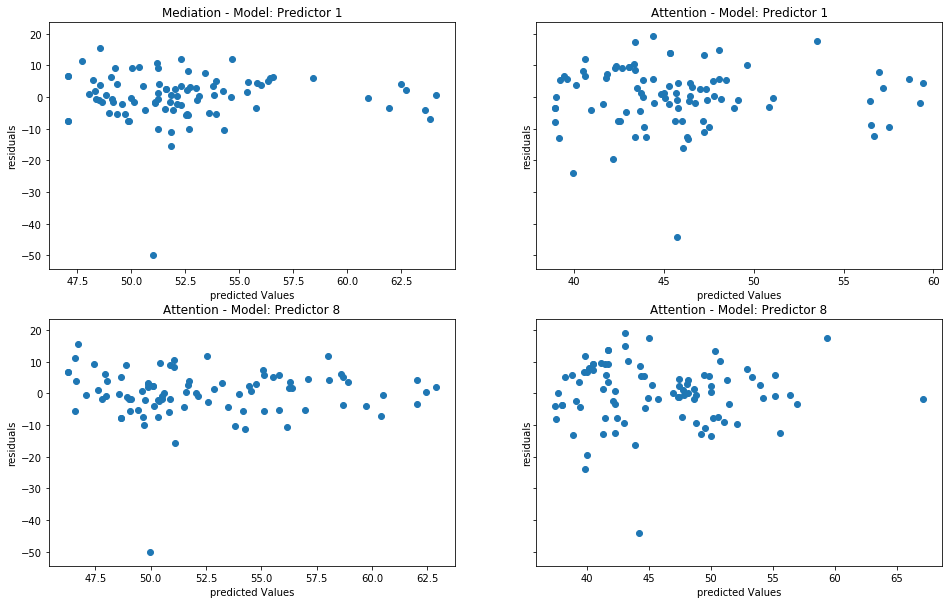

In [255]:
# model with independent predictors
regressor1 = linear_model.LinearRegression()
regressor1.fit(predictor1,criteria1)
criteria1_pred = regressor1.predict(predictor1)
resid1 = criteria1 - criteria1_pred

regressor2 = linear_model.LinearRegression()
regressor2.fit(predictor1,criteria2)
criteria2_pred = regressor2.predict(predictor1)
resid2 = criteria2 - criteria2_pred


# model with interaction
regressor1_inter = linear_model.LinearRegression()
regressor1_inter.fit(predictor8,criteria1)
criteria1_pred_inter = regressor1_inter.predict(predictor8)
resid1 = criteria1 - criteria1_pred_inter

regressor2_inter = linear_model.LinearRegression()
regressor2_inter.fit(predictor8,criteria2)
criteria2_pred_inter = regressor2_inter.predict(predictor8)
resid2 = criteria2 - criteria2_pred_inter


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,10), sharey=True)
ax1.scatter(criteria1_pred, resid1)
ax2.scatter(criteria2_pred, resid2)
ax3.scatter(criteria1_pred_inter, resid1)
ax4.scatter(criteria2_pred_inter, resid2)
ax1.set(title = "Mediation - Model: Predictor 1", xlabel = "predicted Values", ylabel = "residuals")
ax2.set(title = "Attention - Model: Predictor 1", xlabel = "predicted Values", ylabel = "residuals")
ax3.set(title = "Attention - Model: Predictor 8", xlabel = "predicted Values", ylabel = "residuals")
ax4.set(title = "Attention - Model: Predictor 8", xlabel = "predicted Values", ylabel = "residuals")
plt.show()


Both plots show one outlier which might be caused by the subject 4. Futhermore the scatter plot for Attention over residuals clearly shows larger variance. The residuals for the simpler model with independent predictos look slightly more dense around zero. 

## 5 Linear Regression for Prediction

In [256]:
criteria1_pred_cross = cross_val_predict(regressor1, predictor1, criteria1)
RMSE1_cross = sqrt(mean_squared_error(criteria1,criteria1_pred_cross))

criteria2_pred_cross = cross_val_predict(regressor1, predictor1, criteria1)
RMSE2_cross = sqrt(mean_squared_error(criteria2,criteria2_pred_cross))

criteria1_pred_cross_inter = cross_val_predict(regressor1, predictor8, criteria1)
RMSE1_cross_inter = sqrt(mean_squared_error(criteria1,criteria1_pred_cross_inter))

criteria2_pred_cross_inter = cross_val_predict(regressor1, predictor8, criteria1)
RMSE2_cross_inter = sqrt(mean_squared_error(criteria2,criteria2_pred_cross_inter))

print("------- Model: Predictor 1 with independent predictors -------")
print("RMSE for Mediation: %f (cross validated)" % RMSE1_cross)
print("RMSE for Attention: %f (cross validated)" % RMSE2_cross)

print("------- Model: Predictor 8 with interaction between all predictors -------")
print("RMSE for Mediation: %f (cross validated)" % RMSE1_cross_inter)
print("RMSE for Attention: %f (cross validated)" % RMSE2_cross_inter)

------- Model: Predictor 1 with independent predictors -------
RMSE for Mediation: 8.776953 (cross validated)
RMSE for Attention: 12.652841 (cross validated)
------- Model: Predictor 8 with interaction between all predictors -------
RMSE for Mediation: 23.317500 (cross validated)
RMSE for Attention: 26.348364 (cross validated)


As expected the RMSE based on cross validated predictions is larger than the obtained RMSE calculated on the training set in the previouse exercise. The more complex model with interactions shows striking worse results. Which might indicate that it is not able to generalize.

In [257]:
for predictor in pot_predictor: 
    print("-------------------------------")
    regressor1 = linear_model.LinearRegression()
    criteria1_pred_cross = cross_val_predict(regressor1, predictor, criteria1)
    RMSE1_cross = sqrt(mean_squared_error(criteria1,criteria1_pred_cross))
    
    regressor2 = linear_model.LinearRegression()
    criteria2_pred_cross = cross_val_predict(regressor2, predictor, criteria1)
    RMSE2_cross = sqrt(mean_squared_error(criteria2,criteria2_pred_cross))
    
    print("RMSE for Mediation: %f (cross validated)" % RMSE1_cross)
    print("RMSE for Attention: %f (cross validated)" % RMSE2_cross)

print("")
print("")
print("--------- Simple Models -------")

for representative in groups: 
    print("-------------------------------")
    regressor1 = linear_model.LinearRegression()
    criteria1_pred_cross = cross_val_predict(regressor1, dataset_mean[representative].reshape(-1,1), criteria1)
    RMSE1_cross = sqrt(mean_squared_error(criteria1,criteria1_pred_cross))
    
    regressor2 = linear_model.LinearRegression()
    criteria2_pred_cross = cross_val_predict(regressor2, dataset_mean[representative].reshape(-1,1), criteria1)
    RMSE2_cross = sqrt(mean_squared_error(criteria2,criteria2_pred_cross))
    
    print("RMSE for Mediation: %f (cross validated)" % RMSE1_cross)
    print("RMSE for Attention: %f (cross validated)" % RMSE2_cross)
    
print("")
print("")
print("--------- Combining best predictors -------")
print("-------------------------------")
regressor1 = linear_model.LinearRegression()
criteria1_pred_cross = cross_val_predict(regressor1, dataset_mean[[groups[0],groups[2]]], criteria1)
RMSE1_cross = sqrt(mean_squared_error(criteria1,criteria1_pred_cross))
    
regressor2 = linear_model.LinearRegression()
criteria2_pred_cross = cross_val_predict(regressor2, dataset_mean[[groups[0],groups[2]]], criteria1)
RMSE2_cross = sqrt(mean_squared_error(criteria2,criteria2_pred_cross))
    
print("RMSE for Mediation: %f (cross validated)" % RMSE1_cross)
print("RMSE for Attention: %f (cross validated)" % RMSE2_cross)

-------------------------------
RMSE for Mediation: 8.776953 (cross validated)
RMSE for Attention: 12.652841 (cross validated)
-------------------------------
RMSE for Mediation: 8.254723 (cross validated)
RMSE for Attention: 12.515515 (cross validated)
-------------------------------
RMSE for Mediation: 8.308365 (cross validated)
RMSE for Attention: 12.208941 (cross validated)
-------------------------------
RMSE for Mediation: 8.308365 (cross validated)
RMSE for Attention: 12.208941 (cross validated)
-------------------------------
RMSE for Mediation: 8.776953 (cross validated)
RMSE for Attention: 12.652841 (cross validated)
-------------------------------
RMSE for Mediation: 9.380305 (cross validated)
RMSE for Attention: 12.293278 (cross validated)
-------------------------------
RMSE for Mediation: 8.776953 (cross validated)
RMSE for Attention: 12.652841 (cross validated)
-------------------------------
RMSE for Mediation: 23.317500 (cross validated)
RMSE for Attention: 26.348364 (

Since we have already combined predictors and made reasonable assumption we tested the previouse defined models with a cross validated approach. 


For the models without interaction between predictors there was no difference in the three predictor models with changed representatives or when an additonal predictor from the same 'correlation block' was added. Using a model only with correlated predictors had the worst performance. Reducing the amount of predictors slightly improves the errors. The model with delta and gamma 2 waves as predictors performed the best which confirmed our previous assumptions. 

For the models with interaction betwen predictors we saw a collapse in performance. All of them performed much worse on a test set than on a training set which indicates overfitting. Reducing the predictors and interactions led to improvments in the predictions of Mediation and Attention. 

Nevertheless the simple model with independent predictor delta and gamma 2 performed the best which supports the assumption of a linear principle effect of the measured delta and gamma waves on the attention and mediation.